# Collect Results from Training Runs
We'll use MLFlow's Client API to get access to the output files from the runs

In [17]:
%matplotlib inline
from matplotlib import pyplot as plt
from mlflow.artifacts import load_text
from mlflow import MlflowClient
from io import StringIO
import pandas as pd
import numpy as np
import json

## Gather Runs
The runs I want are for the default experiment, `0`. I want the metrics and run parameters for each.

In [2]:
client = MlflowClient()

In [3]:
def gather_run_summaries(exp_name: str = '0') -> list[dict]:
    """Get all runs for a certain experiment
    
    Pulls the metrics, parameters, tags, and the artifact URI (so we can download data later).
    
    Args:
        exp_name: Name of the experiment.
    Returns:
        List of dictionaries describing each run
    """
    
    output = []
    for run in client.search_runs(exp_name):
        record = run.data.tags
        record.update((f'metrics.{k}'.replace(" ", "_"), v) for k, v in run.data.metrics.items())
        record.update((f'params.{k}'.replace(" ", "_"), v) for k, v in run.data.params.items())
        record['artifact.uri'] = run.info.artifact_uri
        output.append(record)
    return output

In [4]:
summary = pd.DataFrame(gather_run_summaries())
summary.head()

,mlflow.source.name,mlflow.runName,mlflow.user,mlflow.source.type,mlflow.source.git.commit,mlflow.log-model.history,metrics.loss,metrics.validation_loss,params.features,params.cuda_version,...,params.test_size,params.depth,params.device_name,params.batch_size,params.nonpeak_weight,params.num_epochs,params.model,params.offset_count,params.kernel_width,artifact.uri
0,0_train-models.py,nebulous-shrew-128,lward,LOCAL,b918c66cd3d2b065d2d4b94608a41f6499c2c054,"[{""run_id"": ""2f8323b14e0248dba8283c6f14a63388""...",0.322882,0.322882,64,11.8,...,1024,3,NVIDIA GeForce RTX 3070 Ti,128,0.01,256,UNetPeakClassifier,256,25,file:///home/lward/Work/AutomatedLabs/nmr-peak...


## Assess the best model
Get the model which treated a full-resolution NMR pattern with the lowest loss on the test set.

In [5]:
best_model = summary.query('`params.offset_count`=="256"').sort_values('metrics.loss', ascending=True).iloc[0]

Pull in the test data. It's stored by MLFlow, we just need to download it

In [19]:
data = pd.read_json(StringIO(load_text(f'{best_model["artifact.uri"]}/test-results.json')), lines=True)
generator_settings = json.loads(load_text(f'{best_model["artifact.uri"]}/test-generator.json'))

In [20]:
generator_settings

{'seed': 2,
 'num_to_generate': 1024,
 'multiplicity_depth_weights': [0.2, 0.7, 0.1],
 'multiplicity_weights': [0.5, 0.45, 0.05],
 'multiplicity_coupling_offset_range': [0.002, 0.02],
 'peak_width_range': [0.0004, 0.001],
 'peak_area_range': [0.02, 1.0],
 'pattern_peak_count_weights': [0.5, 0.4, 0.1],
 'offset_length': 0.2,
 'offset_count': 256}

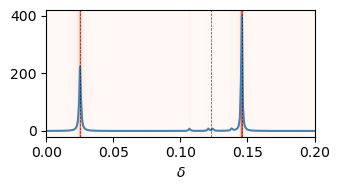

In [31]:
fig, ax = plt.subplots(figsize=(3.5, 2.))

# Plot the known pattern and the locations of the peaks
offsets = np.linspace(0, generator_settings['offset_length'], generator_settings['offset_count'])
example = data.iloc[317]
ax.plot(offsets, example['pattern'], color='steelblue', label='Pattern')
ax.set_ylim(ax.get_ylim())
for peak in example['peak_info']:
    ax.plot([peak['center']] * 2, ax.get_ylim(), 'k--', lw=0.5, alpha=0.7)
    
ax.set_xlim(0, offsets.max())
    
# Plot the peak probability
ax.imshow(np.expand_dims(example['y_pred'], 0), extent=[*ax.get_xlim(), *ax.get_ylim()], alpha=0.7, cmap='Reds', aspect='auto', vmin=0, vmax=1)

ax.set_xlabel('$\\delta$')
fig.tight_layout()